<div>
<img src="figures/svtLogo.png"/>
</div>

<center><h1>Mathematical Optimization for Engineers</h1></center>
<center><h2>Lab 4 - Convergence rates</h2></center>

Let the function $f:\mathcal R^2  \rightarrow \mathcal R$ be defined as
$$f(x,y) = x^2+y^3$$

<u>Task 1</u>: Calculate the first derivative of the function for arbitrary $x$ and $y$.

$$\frac{\partial f}{\partial x}=2x$$
$$\frac{\partial f}{\partial y}=3y^{2}$$


<u>Task 2</u>: Calculate the coordinates of the stationary point.

$$\begin{align}
\frac{\partial f}{\partial x} = 0 &\Leftrightarrow x_{opt}=[0, 0] \\
\frac{\partial f}{\partial y} = 0 &
\end{align}
$$

<u>Task 3</u>: Calculate the Hessian of the function for arbitrary $x$ and $y$.

$ H = \begin{bmatrix} 2 & 0 \\ 0 & 6y \end{bmatrix} $

<u>Task 4</u>: What are the Eigenvalues of the Hessian for arbitrary $x$ and $y$?

$ \lambda = 2 $

$ \lambda = 6y $

<u>Task 5</u>: Check the second-order necessary and the second-order sufficient conditions of the stationary point.

second-order necessary: $H$ is positive semi-definite

second-order sufficient: $H$ is not positive definite

<u>Task 6</u>: Characterize the stationary point.

The stationary point is not a local minimum, nor a local maximum.

In this lab, you have the opportunity to experiment with different solvers for unconstrained optimization.

We have implemented the following solvers for you:<br><br>
(a) steepest_descent with armijo step-length<br>
(b) steepest_descent with wolfe step-length<br>
(c) steepest_descent with constant step-length<br>
(d) newton's method<br>
(e) inexact newton's method with CG (from scipy)<br>
(f) CG method (from scipy)<br>
(g) bfgs method (from scipy)

Moreover, you can test these methods on several different objective functions defined below.

Try to answer the following questions:<br>
1. What happens when you change the initial point? and why? <br>
2. Are the given problems convex or non-convex? <br>
3. By looking at the convergence plots, can you identify linear, order-p or super-linear convergence rates?
4. Which parameters can you change in different solvers to improve/worsen their respective performances?

### Imports

In [1]:
import autograd.numpy as np

import scipy.optimize as minimize

from numpy.linalg import inv

from autograd import grad
from autograd import hessian
from autograd import elementwise_grad as egrad

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.ticker

### Plot

In [2]:
# You can ignore this cell. It only serves to create nice plots.
def plot_optimization(func, xIter):
    
    x1 = []
    x2 = []
    f = []
    
    x1 = [elx[0] for elx in xIter]
    x2 = [ely[1] for ely in xIter]
    f = [func([i,j]) for i,j in zip(x1,x2)]
    
    fig = plt.figure(figsize=(10,10)) # create figure
    ax = fig.add_subplot(111,projection='3d' )
    ax.view_init(elev=30, azim=30)
    
    ax.plot(x1, x2, f, linestyle="dashed",linewidth=1, color="red")

    for it in range(len(f)):
        ax.scatter(x1[it],x2[it],f[it], marker='x', color="red")
    
    xmax = max(x1)
    xmin = min(x1)
    ymax = max(x2)
    ymin = min(x2)
    
    X = np.linspace(xmin-1, xmax+1)
    Y = np.linspace(ymin-1, ymax+1)
    X, Y = np.meshgrid(X, Y)
    
    zs = np.array(func([np.ravel(X), np.ravel(Y)]))
    Z = zs.reshape(X.shape)
    
    # Surface plot:
    ax.plot_surface(X, Y, Z, cmap=plt.cm.jet, antialiased=True,cstride=1,rstride=1, alpha=0.75)

    plt.show()

### Objective functions

In [3]:
def sixhump(x): #scipy-lectures.org/intro/scipy/auto_examples/plot_2d_minimization.html
    return ((4 - 2.1*x[0]**2 + x[0]**4 / 3.) * x[0]**2 + x[0] * x[1] + (-4 + 4*x[1]**2) * x[1] **2)

In [4]:
def rosen(x): #scipy-lectures.org/intro/scipy/auto_examples/plot_2d_minimization.html
    return ((x[0]-1)**2 + 100*(x[1]-x[0]**2)**2)

In [5]:
def beale(X):
    x, y = X[0], X[1]
    return ((1.500 - x + x*y)**2 + (2.250 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2)

In [6]:
def adjiman (X):
    x, y = X[0], X[1]
    return (np.cos(x) * np.sin(y)) - (x / (y**2.0 + 1.0))

In [7]:
from mpl_toolkits.mplot3d import Axes3D
def visualize_function(obj_fun):
    x = np.linspace(-2, 2)
    y = np.linspace(-1, 1)
    xg, yg = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(xg, yg, obj_fun([xg, yg]), rstride=1, cstride=1,
                           cmap=plt.cm.jet, linewidth=0, antialiased=False)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x, y)')

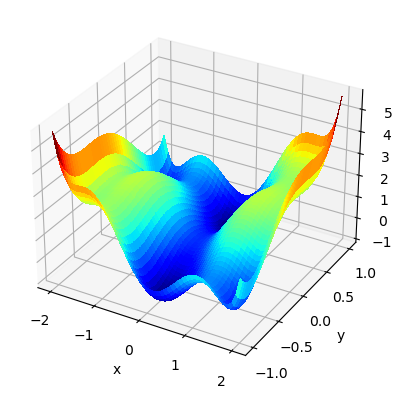

In [8]:
visualize_function(sixhump)

### Gradient

In [9]:
def gradient_function(func, x): 
    return grad(func)(x)

### Hessian

In [10]:
def hessian_function(func,x):
    return hessian(func)(x)

### Steepest descent

In [11]:
# input: (objective function, initial guess, step rule, c1, c2, initial alpha, optimality tolerance)
def steepest_descent(function, x0, stepRule, c1, c2, alpha0, tol=0.01):     
    
    xCur = x0
    fcur = function(xCur)
    gCur = gradient_function(function,xCur)
    
    # norm of the gradient at initial point for optimality condition
    nmg0 = np.linalg.norm(gradient_function(function, x0))
    
    # count number of steps taken by method
    it = 0
    
    # accumulate number of iterations needed by linesearch algorithm in every step
    ls_iter = 0
    
    # store iterates for plotting
    xIter=[]
    xIter.append(x0)
    
    while(np.linalg.norm(gCur)>tol*min(1,nmg0)): 

        it=it+1
        
        # calculate descent direction
        direction = -1.0 * gradient_function(function,xCur)
        
        # calculate step-length
        if (stepRule=='armijo'):
            alpha, ls_ = armijo(function,xCur,direction, c1, alpha0)
        elif (stepRule=='wolfe'):
            alpha, ls_ = wolfe(function,xCur,direction, c1, c2, alpha0)
        else:
            alpha = 0.001
            ls_ = 1
        ls_iter = ls_iter + ls_
        
        # update current point
        xCur = xCur + alpha * direction
        gCur = gradient_function(function,xCur)
        fcur = function(xCur)
        xIter.append(xCur)

    return xCur, fcur, it, xIter

### Newton's method

In [12]:
# input: (objective function, initial guess, optimality tolerance)
def newton_descent(function, x0, tol=0.01): 

    xCur = x0
    fcur = function(xCur)
    gCur = gradient_function(function,xCur)
    hCur = hessian_function(function,xCur)    
    
    # norm of the gradient at initial point for optimality condition
    nmg0 = np.linalg.norm(gradient_function(function, x0))    
    
    # count number of steps taken by method    
    it = 0
    
    # store iterates for plotting    
    xIter=[]
    xIter.append(x0)
    
    while(np.linalg.norm(gCur)>tol*min(1,nmg0)):
        
        it=it+1
        
        # calculate descent direction
        direction = -1.0 * np.dot(inv(hCur),gCur)
        
        # calculate step-length
        alpha = 1.0
        
        # update current point
        xCur = xCur + alpha * direction
        fcur = function(xCur)        
        gCur = gradient_function(function,xCur)
        hCur = hessian_function(function,xCur)
        xIter.append(xCur)

    return xCur, fcur, it, xIter

### BFGS (scipy)

In [13]:
def bfgs_scipy(func, x0):

    global Nfeval
    global xIter    
    Nfeval = 0
    xIter=[]
    xIter.append(x0)
    
    def callbackF(Xi):

        global Nfeval
        global xIter 
        Nfeval += 1    
        xIter.append(Xi)
    
    [xopt, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = \
        minimize.fmin_bfgs(func, x0, callback=callbackF, maxiter=2000, full_output=True, disp=False, retall=False)
    
    return xopt, fopt, Nfeval, xIter

### CG (scipy)

In [14]:
def cg_scipy(func, x0):

    global Nfeval
    global xIter    
    Nfeval = 0
    xIter=[]
    xIter.append(x0)
    
    def callbackF(Xi):

        global Nfeval
        global xIter 
        Nfeval += 1    
        xIter.append(Xi)
    
    [xopt, fopt, func_calls, grad_calls, warnflg] = \
        minimize.fmin_cg(func, x0, callback=callbackF, maxiter=2000, full_output=True, disp=False, retall=False)
    
    return xopt, fopt, Nfeval, xIter

### Newton with CG (scipy)

In [15]:
def ncg_scipy(func, x0):

    global Nfeval
    global xIter    
    Nfeval = 0
    xIter=[]
    xIter.append(x0)
    
    def callbackF(Xi):

        global Nfeval
        global xIter 
        Nfeval += 1    
        xIter.append(Xi)
        
    fprime = grad(func)
    fhess = hessian(func)
    
    [xopt, fopt, func_calls, grad_calls, hess_calls,  warnflg] = \
        minimize.fmin_ncg(func, x0, fprime, callback=callbackF, full_output=True, disp=False, retall=False)
    
    return xopt, fopt, Nfeval, xIter

### Armijo

In [16]:
def armijo(function, xcur, searchdirection, c1, alpha0): 
    #f(x+alpha p) \leq f(x) + c1 alpha grad(f).p
    
    alpha = alpha0
    xnew = xcur + alpha * searchdirection
    fcur = function(xcur)
    fnew = function(xnew)
    gradientCur = gradient_function(function,xcur)
    numiter = 0
    # check for Armijo condition
    while ((fnew) > (fcur + c1 * alpha * np.dot(gradientCur,searchdirection))): 
        numiter += 1
        alpha = alpha/2.0
        xnew = xcur + alpha * searchdirection
        fnew = function(xnew)

    return alpha, numiter

### Wolfe

In [17]:
def wolfe(function, xcur, searchdirection, c1, c2, alpha0): 
    #f(x+alpha p) \leq f(x) + c1 alpha grad(f)Tp
    #grad(f(x+alpha p))Tp \geq c2 grad(f)Tp
    
    alpha = alpha0
    xnew = xcur + alpha * searchdirection
    fcur = function(xcur)
    fnew = function(xnew)
    gradientCur = gradient_function(function,xcur)
    gradientNew = gradient_function(function,xnew)
    numiter = 0
    
    lb = 0
    ub = np.inf 
    
    # check for Wolfe conditions
    # adapted from https://sites.math.washington.edu/~burke/crs/408/notes/nlp/line.pdf (pg. 8)
    while True: 
        numiter += 1
        if ((fnew) > (fcur + c1 * alpha * np.dot(gradientCur,searchdirection))):
            ub = alpha
            alpha = 0.5 * (lb + ub)
        elif (np.dot(gradientNew,searchdirection) < c2 * np.dot(gradientCur,searchdirection)):
        #elif (np.abs(np.dot(gradientNew,searchdirection)) > c2 * np.abs(np.dot(gradientCur,searchdirection))):
            lb = alpha
            if np.isinf(ub):
                alpha = 2 * lb
            else:
                alpha = 0.5 * (lb + ub)
        else:
            break
        xnew = xcur + alpha * searchdirection
        fnew = function(xnew)
        gradientNew = gradient_function(function,xnew)

    return alpha, numiter

### Calls Rosenbrock

In [18]:
# initial point
x0 = np.array([-2., 2.])

c1 = 0.5 
c2 = 0.6 
alpha0 = 0.125 
tol = 0.0001

num_last_iters = 3
xoptStar = [1.0, 1.0]  # optimal point

# a: steepest_descent armijo
# b: steepest_descent wolfe
# c: steepest_descent constant
# d: newton
# e: ncg_scipy
# f: cg_scipy
# g: bfgs_scipy

In [19]:
# calling all solvers
xopt_a, fopt_a, it_a, xIter_a = steepest_descent(rosen, x0, 'armijo', c1, c2, alpha0)
xopt_b, fopt_b, it_b, xIter_b = steepest_descent(rosen, x0, 'wolfe', c1, c2, alpha0)
xopt_c, fopt_c, it_c, xIter_c = steepest_descent(rosen, x0, 'constant', c1, c2, alpha0)
xopt_d, fopt_d, it_d, xIter_d = newton_descent(rosen, x0)
xopt_e, fopt_e, it_e, xIter_e = ncg_scipy(rosen, x0)
xopt_f, fopt_f, it_f, xIter_f = cg_scipy(rosen, x0)
xopt_g, fopt_g, it_g, xIter_g = bfgs_scipy(rosen, x0)

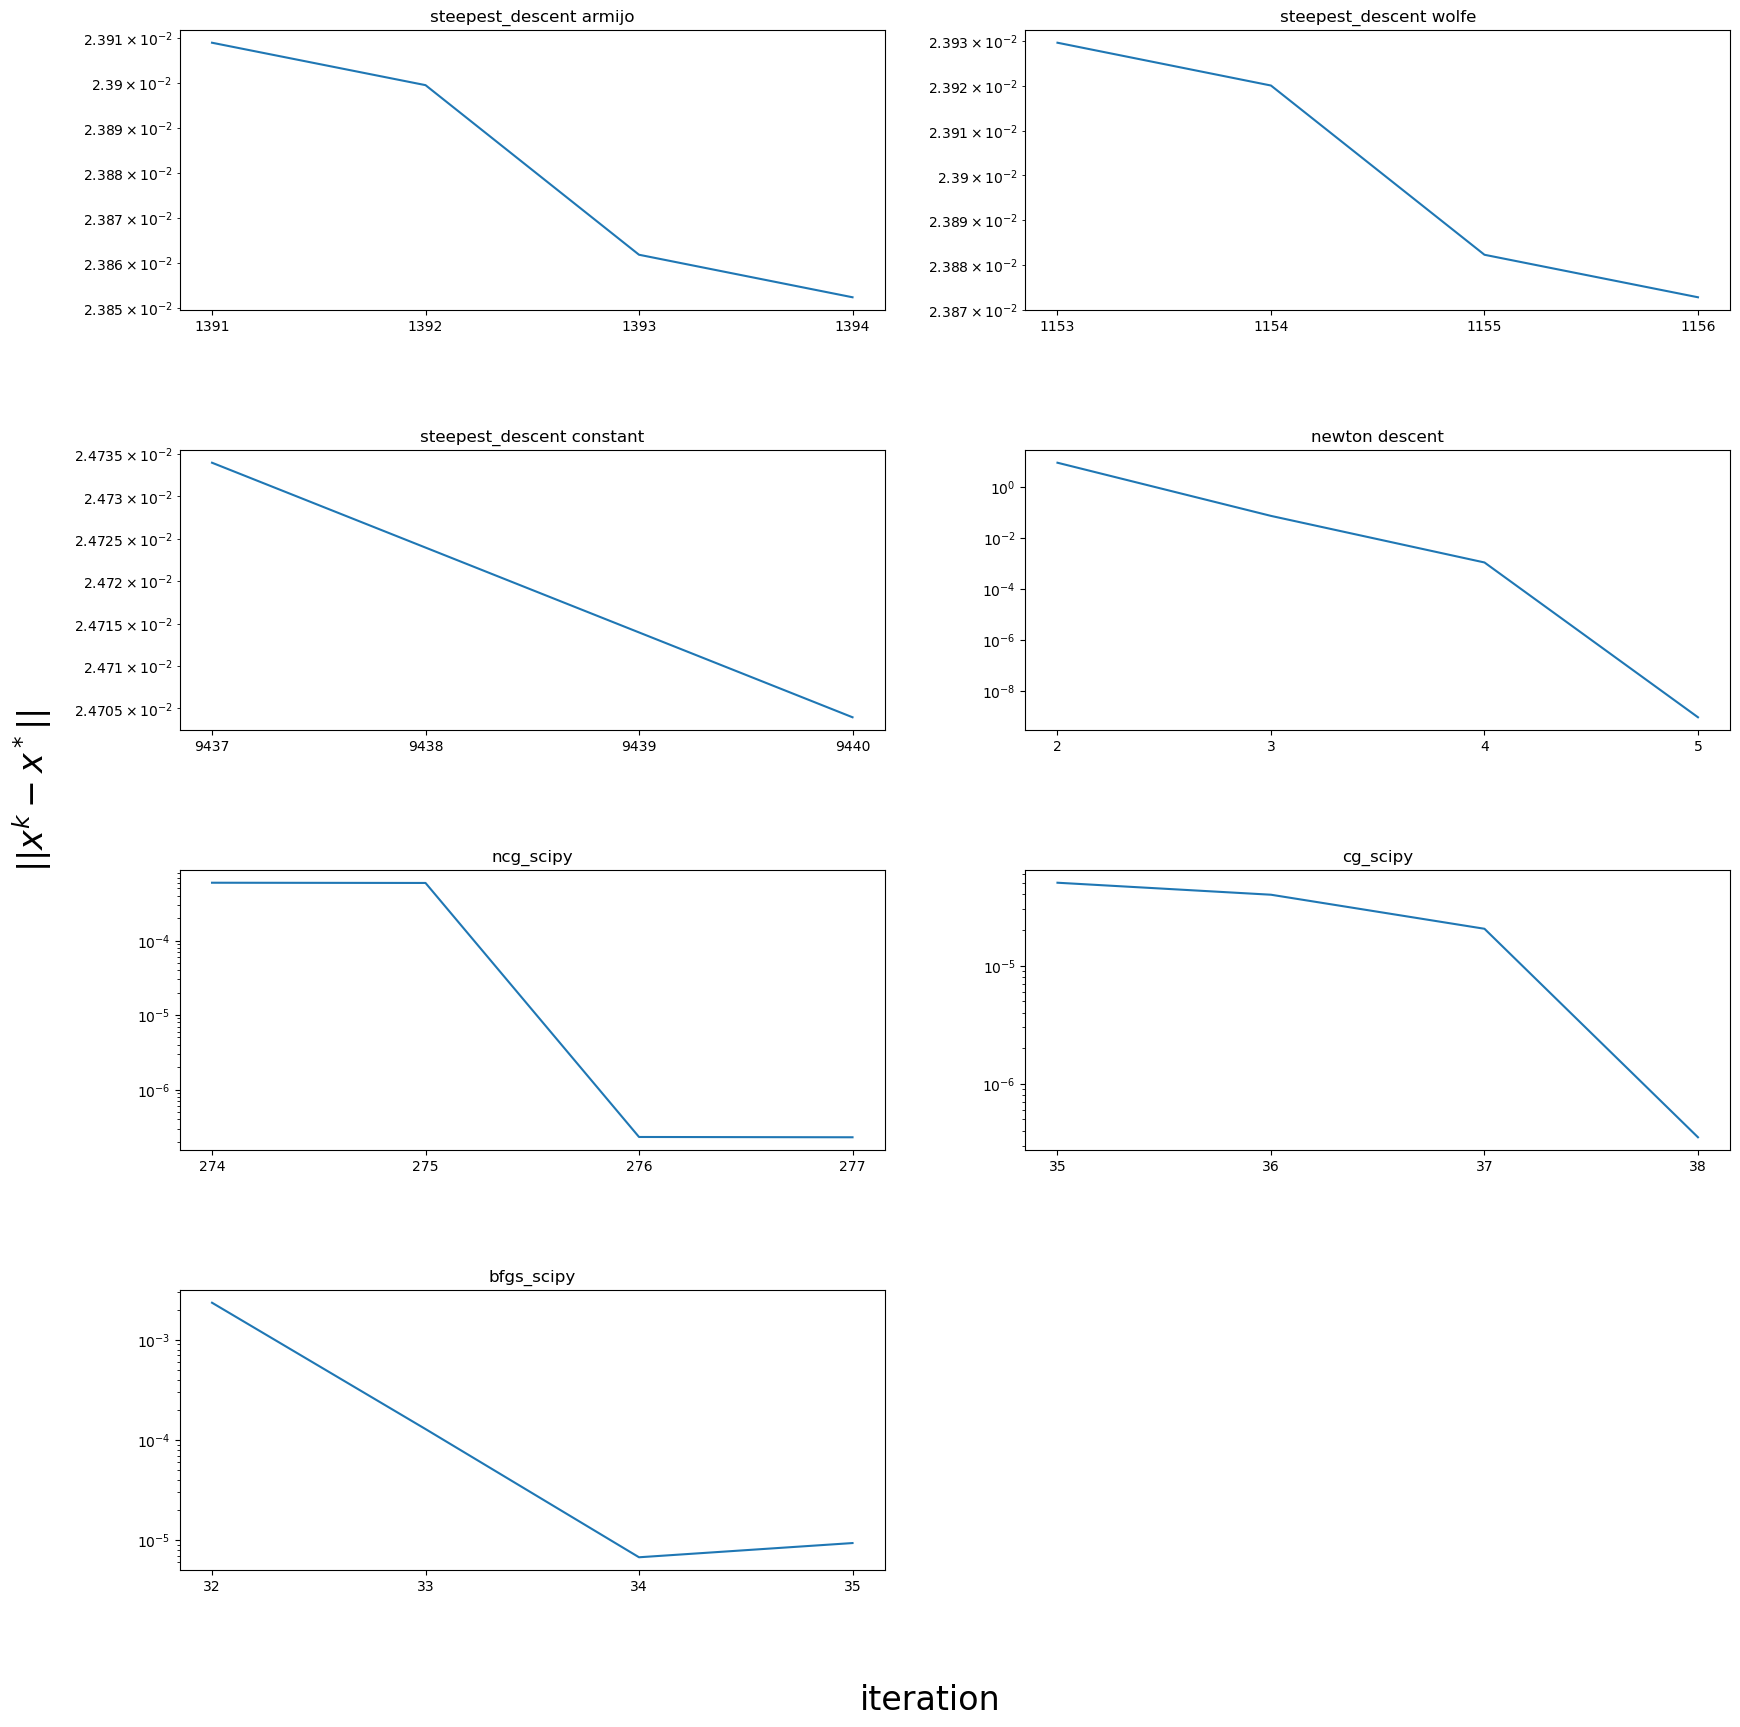

In [20]:
# plotting
# you can ignore this cell
# here, we simply plot convergence on y-axis v/s the last four iterations of the solver
diff_a = [np.linalg.norm(iterate - xoptStar) for iterate in xIter_a]
diff_b = [np.linalg.norm(iterate - xoptStar) for iterate in xIter_b]
diff_c = [np.linalg.norm(iterate - xoptStar) for iterate in xIter_c]
diff_d = [np.linalg.norm(iterate - xoptStar) for iterate in xIter_d]
diff_e = [np.linalg.norm(iterate - xoptStar) for iterate in xIter_e]
diff_f = [np.linalg.norm(iterate - xoptStar) for iterate in xIter_f]
diff_g = [np.linalg.norm(iterate - xoptStar) for iterate in xIter_g]

fig, ax = plt.subplots(4, 2, figsize=(20,20))
fig.text(0.5, 0.04, 'iteration',fontsize = 24, ha='center')
fig.text(0.04, 0.5, '$||x^k - x^*||$',fontsize = 24, va='center', rotation='vertical')

ax[0, 0].plot(list(range(it_a-num_last_iters, it_a+1)),diff_a[it_a-num_last_iters:it_a+1])
ax[0, 1].plot(list(range(it_b-num_last_iters, it_b+1)),diff_b[it_b-num_last_iters:it_b+1])
ax[1, 0].plot(list(range(it_c-num_last_iters, it_c+1)),diff_c[it_c-num_last_iters:it_c+1])
ax[1, 1].plot(list(range(it_d-num_last_iters, it_d+1)),diff_d[it_d-num_last_iters:it_d+1])
ax[2, 0].plot(list(range(it_e-num_last_iters, it_e+1)),diff_e[it_e-num_last_iters:it_e+1])
ax[2, 1].plot(list(range(it_f-num_last_iters, it_f+1)),diff_f[it_f-num_last_iters:it_f+1])
ax[3, 0].plot(list(range(it_g-num_last_iters, it_g+1)),diff_g[it_g-num_last_iters:it_g+1])
ax[3, 1].axis('off')

ax[0, 0].set_xticks(np.arange(it_a-num_last_iters, it_a+1, 1))
ax[0, 1].set_xticks(np.arange(it_b-num_last_iters, it_b+1, 1))
ax[1, 0].set_xticks(np.arange(it_c-num_last_iters, it_c+1, 1))
ax[1, 1].set_xticks(np.arange(it_d-num_last_iters, it_d+1, 1))
ax[2, 0].set_xticks(np.arange(it_e-num_last_iters, it_e+1, 1))
ax[2, 1].set_xticks(np.arange(it_f-num_last_iters, it_f+1, 1))
ax[3, 0].set_xticks(np.arange(it_g-num_last_iters, it_g+1, 1))

ax[0, 0].title.set_text('steepest_descent armijo')
ax[0, 1].title.set_text('steepest_descent wolfe')
ax[1, 0].title.set_text('steepest_descent constant')
ax[1, 1].title.set_text('newton descent')
ax[2, 0].title.set_text('ncg_scipy')
ax[2, 1].title.set_text('cg_scipy')
ax[3, 0].title.set_text('bfgs_scipy')

ax[0, 0].set_yscale('log')
ax[0, 1].set_yscale('log')
ax[1, 0].set_yscale('log')
ax[1, 1].set_yscale('log')
ax[2, 0].set_yscale('log')
ax[2, 1].set_yscale('log')
ax[3, 0].set_yscale('log')

plt.subplots_adjust(hspace=0.5)
plt.show()

### Adjiman function

In [21]:
# initial point
x0 = np.array([-2., 2.])

c1 = 0.5 
c2 = 0.6 
alpha0 = 0.125 
tol = 0.0001

num_last_iters = 3
xoptStar = np.array([-2.92293048, 2.04457258])  # approx optimum

# a: steepest_descent armijo
# b: steepest_descent wolfe
# c: steepest_descent constant
# d: newton
# e: ncg_scipy
# f: cg_scipy
# g: bfgs_scipy

In [22]:
# calling all solvers
xopt_a, fopt_a, it_a, xIter_a = steepest_descent(adjiman, x0, 'armijo', c1, c2, alpha0)
xopt_b, fopt_b, it_b, xIter_b = steepest_descent(adjiman, x0, 'wolfe', c1, c2, alpha0)
xopt_c, fopt_c, it_c, xIter_c = steepest_descent(adjiman, x0, 'constant', c1, c2, alpha0)
xopt_d, fopt_d, it_d, xIter_d = newton_descent(adjiman, x0)
xopt_e, fopt_e, it_e, xIter_e = ncg_scipy(adjiman, x0)
xopt_f, fopt_f, it_f, xIter_f = cg_scipy(adjiman, x0)
xopt_g, fopt_g, it_g, xIter_g = bfgs_scipy(adjiman, x0)

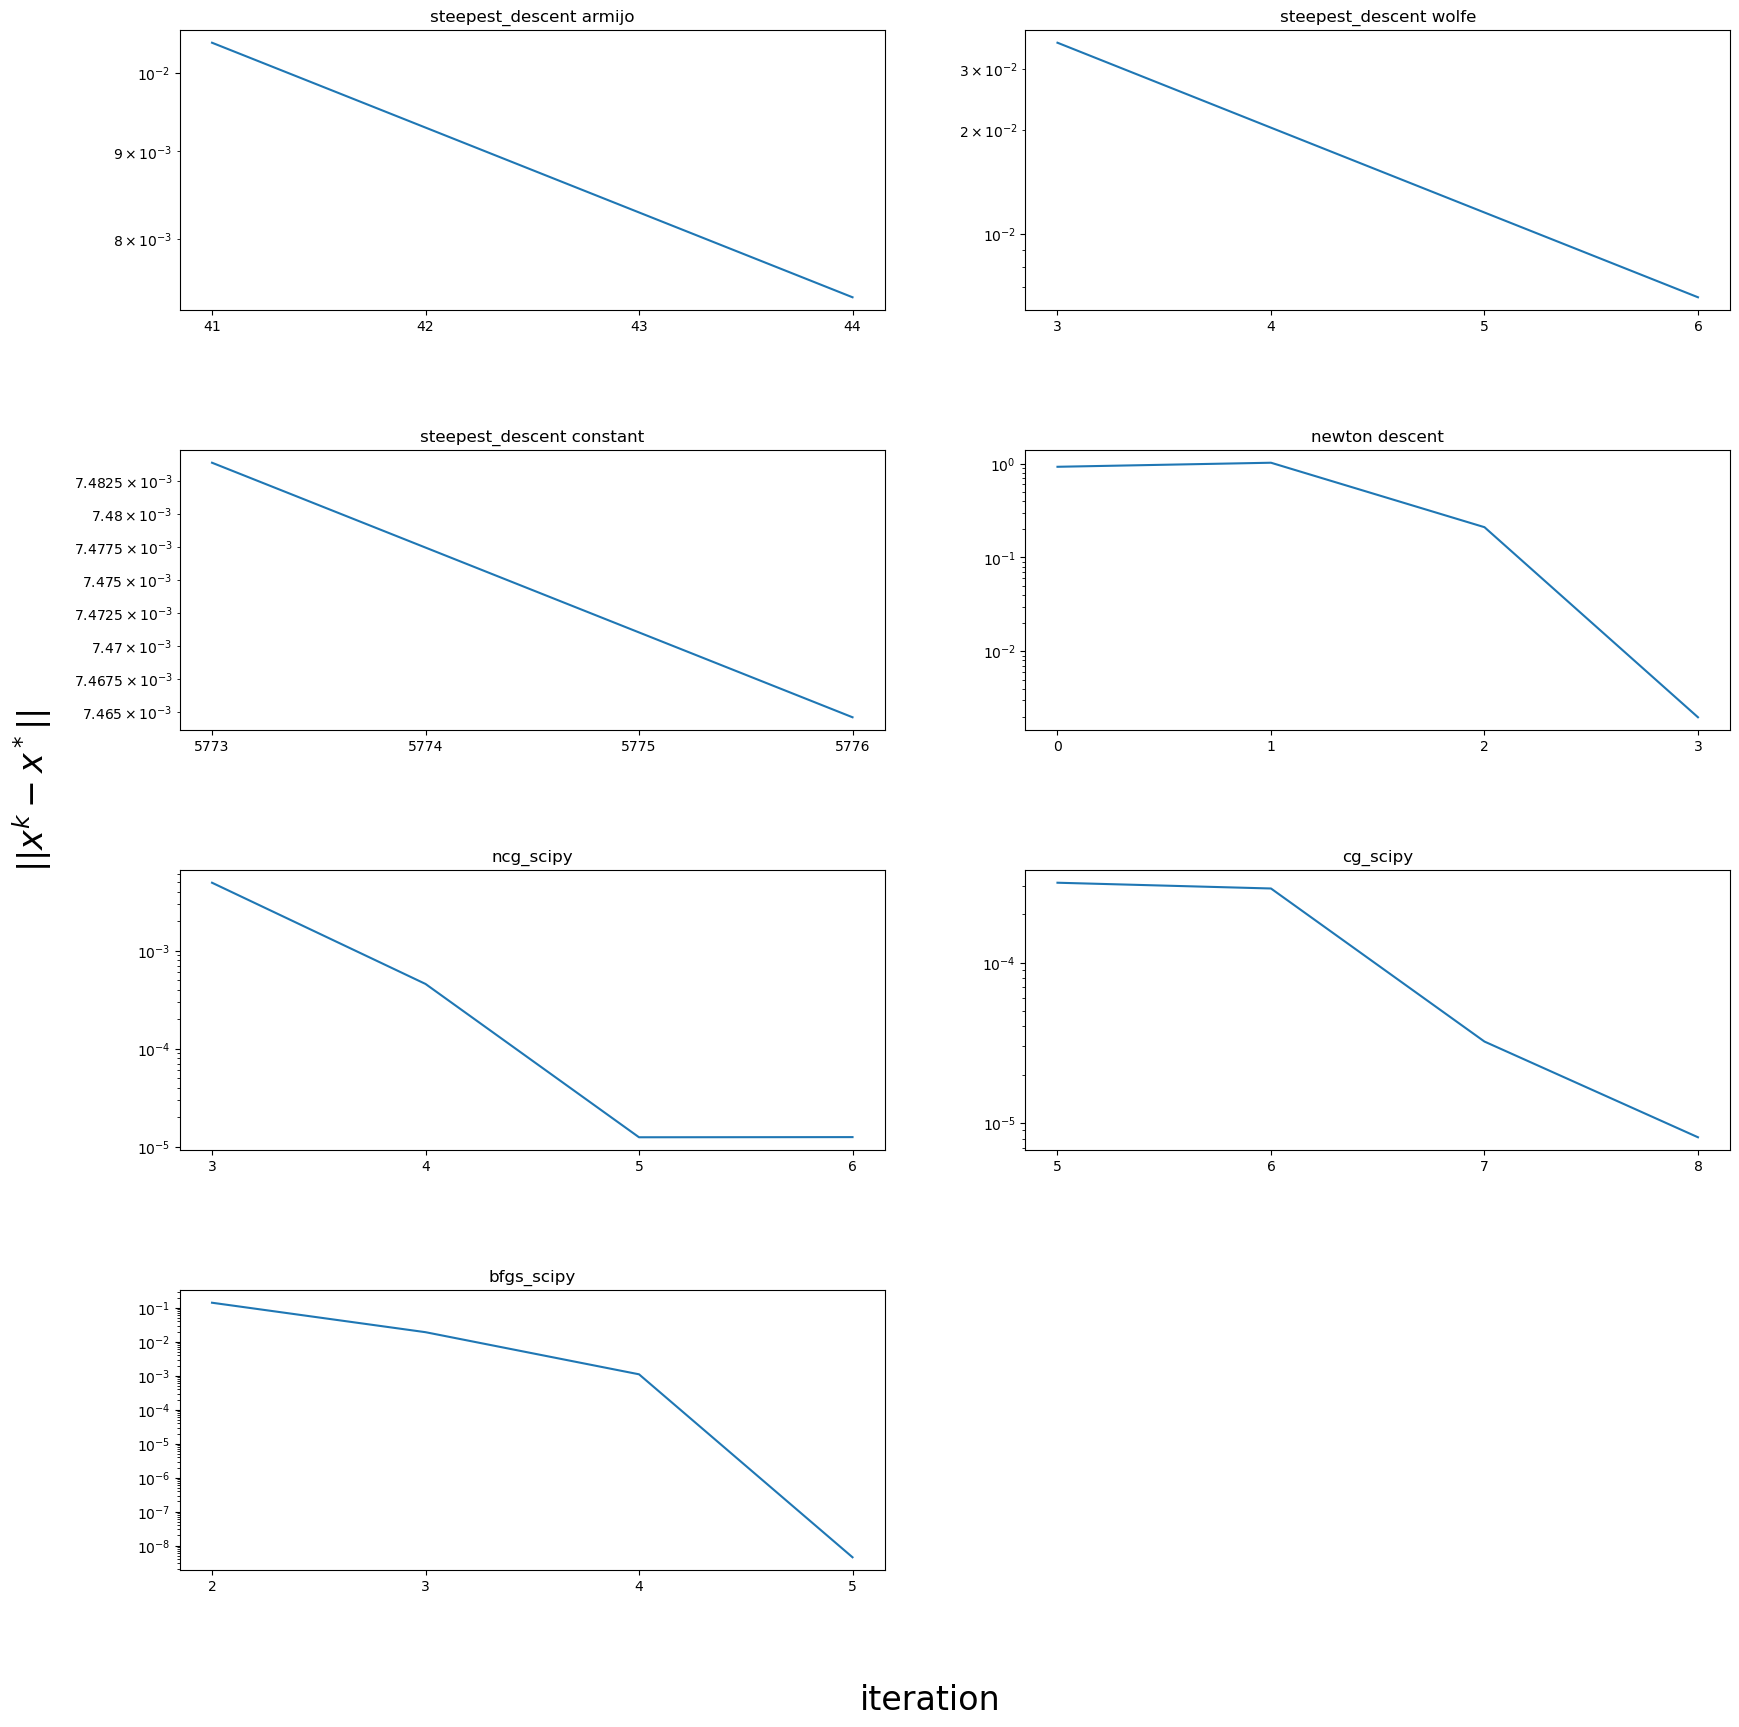

In [23]:
# plotting
# you can ignore this cell
# here, we simply plot convergence on y-axis v/s the last four iterations of the solver
diff_a = [np.linalg.norm(iterate - xoptStar) for iterate in xIter_a]
diff_b = [np.linalg.norm(iterate - xoptStar) for iterate in xIter_b]
diff_c = [np.linalg.norm(iterate - xoptStar) for iterate in xIter_c]
diff_d = [np.linalg.norm(iterate - xoptStar) for iterate in xIter_d]
diff_e = [np.linalg.norm(iterate - xoptStar) for iterate in xIter_e]
diff_f = [np.linalg.norm(iterate - xoptStar) for iterate in xIter_f]
diff_g = [np.linalg.norm(iterate - xoptStar) for iterate in xIter_g]

fig, ax = plt.subplots(4, 2,figsize=(20,20))
fig.text(0.5, 0.04, 'iteration',fontsize = 24, ha='center')
fig.text(0.04, 0.5, '$||x^k - x^*||$',fontsize = 24, va='center', rotation='vertical')

ax[0, 0].plot(list(range(it_a-num_last_iters, it_a+1)),diff_a[it_a-num_last_iters:it_a+1])
ax[0, 1].plot(list(range(it_b-num_last_iters, it_b+1)),diff_b[it_b-num_last_iters:it_b+1])
ax[1, 0].plot(list(range(it_c-num_last_iters, it_c+1)),diff_c[it_c-num_last_iters:it_c+1])
ax[1, 1].plot(list(range(it_d-num_last_iters, it_d+1)),diff_d[it_d-num_last_iters:it_d+1])
ax[2, 0].plot(list(range(it_e-num_last_iters, it_e+1)),diff_e[it_e-num_last_iters:it_e+1])
ax[2, 1].plot(list(range(it_f-num_last_iters, it_f+1)),diff_f[it_f-num_last_iters:it_f+1])
ax[3, 0].plot(list(range(it_g-num_last_iters, it_g+1)),diff_g[it_g-num_last_iters:it_g+1])
ax[3, 1].axis('off')

ax[0, 0].set_xticks(np.arange(it_a-num_last_iters, it_a+1, 1))
ax[0, 1].set_xticks(np.arange(it_b-num_last_iters, it_b+1, 1))
ax[1, 0].set_xticks(np.arange(it_c-num_last_iters, it_c+1, 1))
ax[1, 1].set_xticks(np.arange(it_d-num_last_iters, it_d+1, 1))
ax[2, 0].set_xticks(np.arange(it_e-num_last_iters, it_e+1, 1))
ax[2, 1].set_xticks(np.arange(it_f-num_last_iters, it_f+1, 1))
ax[3, 0].set_xticks(np.arange(it_g-num_last_iters, it_g+1, 1))

ax[0, 0].title.set_text('steepest_descent armijo')
ax[0, 1].title.set_text('steepest_descent wolfe')
ax[1, 0].title.set_text('steepest_descent constant')
ax[1, 1].title.set_text('newton descent')
ax[2, 0].title.set_text('ncg_scipy')
ax[2, 1].title.set_text('cg_scipy')
ax[3, 0].title.set_text('bfgs_scipy')

ax[0, 0].set_yscale('log')
ax[0, 1].set_yscale('log')
ax[1, 0].set_yscale('log')
ax[1, 1].set_yscale('log')
ax[2, 0].set_yscale('log')
ax[2, 1].set_yscale('log')
ax[3, 0].set_yscale('log')

plt.subplots_adjust(hspace=0.5)
plt.show()